# Neurons example, pt. 1
## Generate some data

In [1]:
from bayes_window import models, fake_spikes_explore, BayesWindow
from bayes_window.generative_models import generate_fake_spikes
from importlib import reload
import numpy as np
import altair as alt
alt.renderers.enable('altair_saver', fmts=['png']);

In [2]:

df, df_monster, index_cols, firing_rates = generate_fake_spikes(n_trials=20,
                                                                n_neurons=6,
                                                                n_mice=3,
                                                                dur=5,
                                                               mouse_response_slope=40,
                                                               overall_stim_response_strength=5)


## Exploratory plot without any fitting

Three mice, five neurons each. Mouse #0/neuron #4 has the least effect, mouse #2/neuron #0 the most

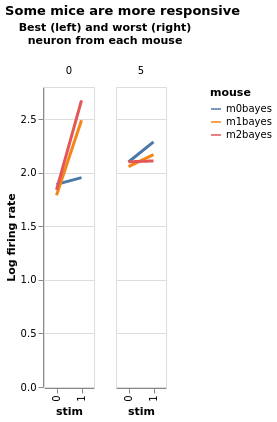

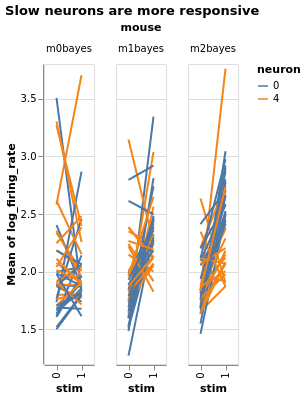

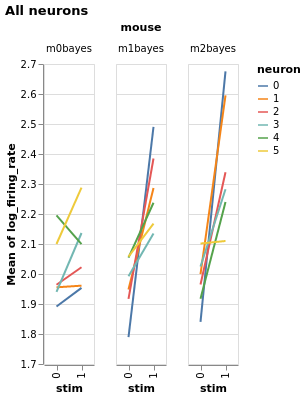

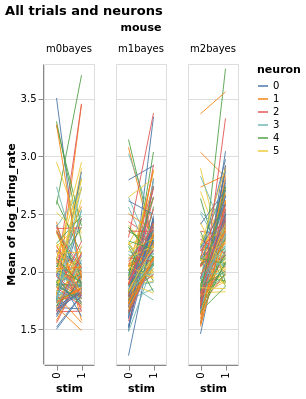

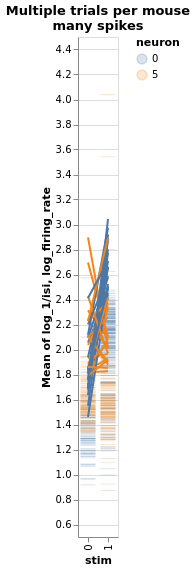

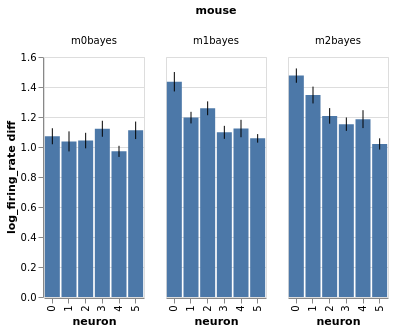

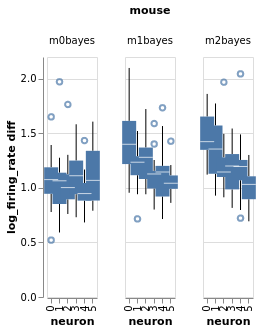

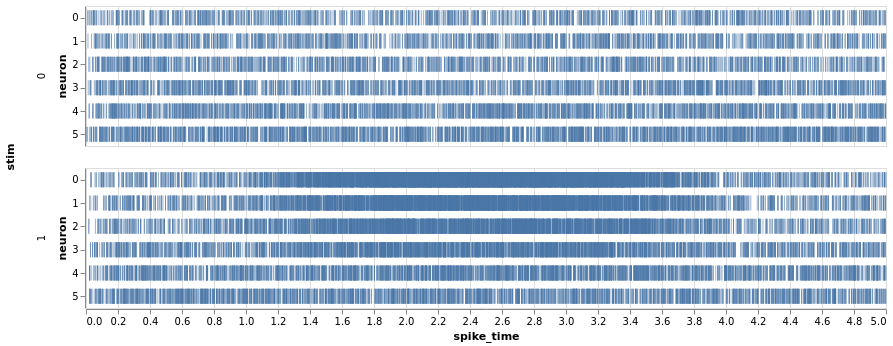

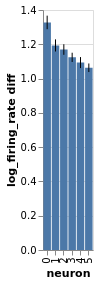

In [4]:

charts=fake_spikes_explore(df,df_monster,index_cols)
[chart.display() for chart in charts];
#fig_mice, fig_select, fig_neurons, fig_trials, fig_isi + fig_overlay, bar, box, fig_raster, bar_combined

## Estimate with neuron as condition

### ISI

In [5]:
df['log_isi']=np.log10(df['isi'])

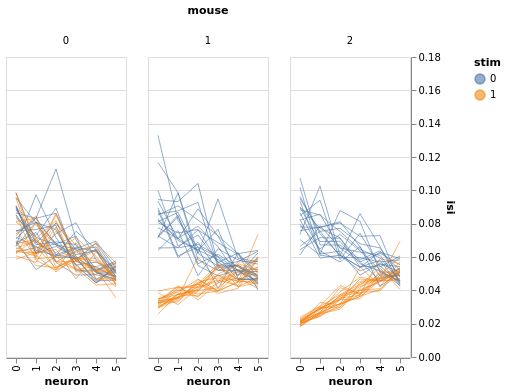

In [6]:
alt.data_transformers.disable_max_rows()
bw = BayesWindow(df_monster, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.plot(x='neuron',color='stim',detail='i_trial',add_box=False).facet(column='mouse',)

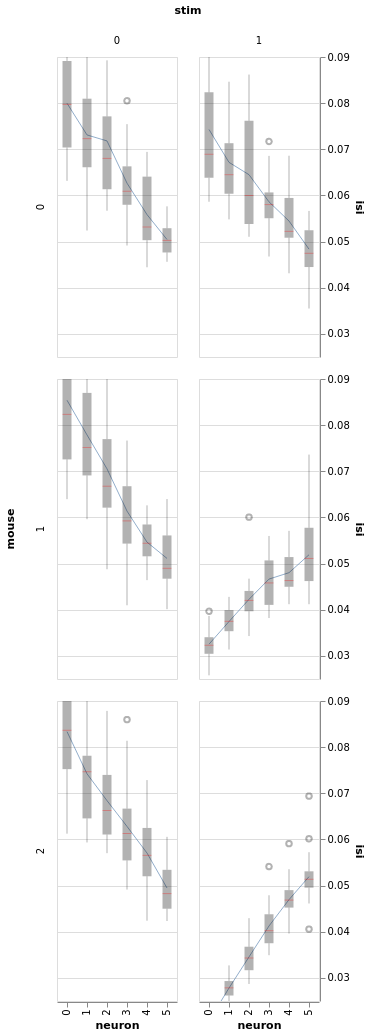

In [7]:
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.plot(x='neuron',add_box=True).facet(row='mouse',column='stim')

## Vanilla regression

In [11]:
bw.levels

['stim', 'neuron', 'mouse', 'mouse']

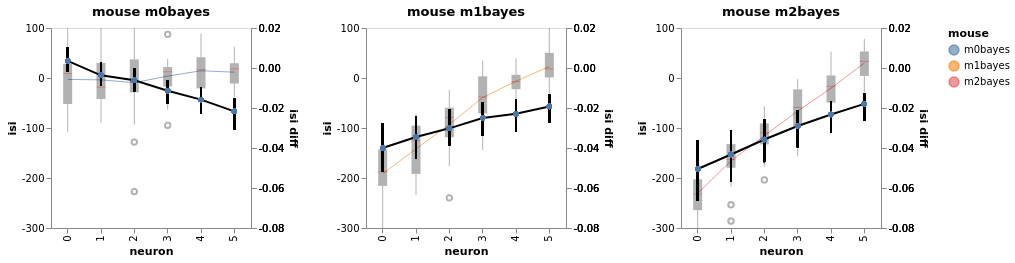

In [12]:
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse', detail='i_trial')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='normal',
              robust_slopes=False,
              add_group_slope=False,
              add_group_intercept=True,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse', 'i_trial')
             )

bw.plot(x='neuron', color='mouse', independent_axes=True, finalize=True, add_box=True)


bw.facet(column='mouse',width=200,height=200).display()

## GLM
($y\sim Gamma(\theta)$)

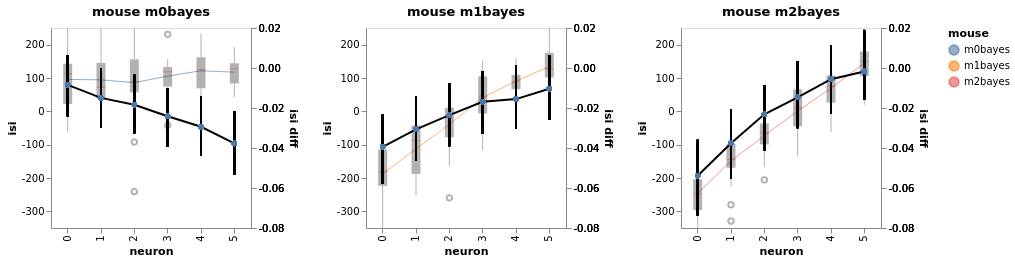

In [14]:
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse', detail='i_trial')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='gamma',
              robust_slopes=False,
              add_group_slope=True,
              add_group_intercept=True,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse','i_trial'))

bw.plot(x='neuron', color='mouse', independent_axes=True, finalize=True, add_box=True)


bw.facet(column='mouse',width=200,height=200).display()

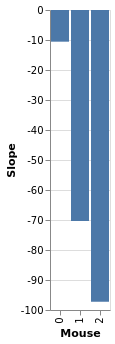

In [15]:
import altair as alt
slopes=bw.trace.posterior['slope_per_group'].mean(['chain','draw']).to_dataframe().reset_index()
chart_slopes=alt.Chart(slopes).mark_bar().encode(
    x=alt.X('mouse_:O',title='Mouse'),
    y=alt.Y('slope_per_group', title='Slope')
)
chart_slopes

In [16]:
bw = BayesWindow(df, y='firing_rate', treatment='stim', condition='neuron_x_mouse', group='mouse',)
#bw.fit_anova()
bw.fit_lme()

Using formula firing_rate ~ (1|mouse) + stim| neuron_x_mouse__0 + stim|neuron_x_mouse__1 + stim|neuron_x_mouse__2 + stim|neuron_x_mouse__3 + stim|neuron_x_mouse__4 + stim|neuron_x_mouse__5 + stim|neuron_x_mouse__6 + stim|neuron_x_mouse__7 + stim|neuron_x_mouse__8 + stim|neuron_x_mouse__9 + stim|neuron_x_mouse__10 + stim|neuron_x_mouse__11 + stim|neuron_x_mouse__12 + stim|neuron_x_mouse__13 + stim|neuron_x_mouse__14 + stim|neuron_x_mouse__15 + stim|neuron_x_mouse__16 + stim|neuron_x_mouse__17
                              Coef. Std.Err.       z  P>|z|    [0.025   0.975]
Intercept                    49.301   47.238   1.044  0.297   -43.284  141.886
1 | mouse                    58.782   24.305   2.419  0.016    11.145  106.419
stim | neuron_x_mouse__0    123.207   94.030   1.310  0.190   -61.088  307.501
stim | neuron_x_mouse__1     73.538   94.030   0.782  0.434  -110.756  257.833
stim | neuron_x_mouse__2      0.155   94.030   0.002  0.999  -184.139  184.450
stim | neuron_x_mouse__3     

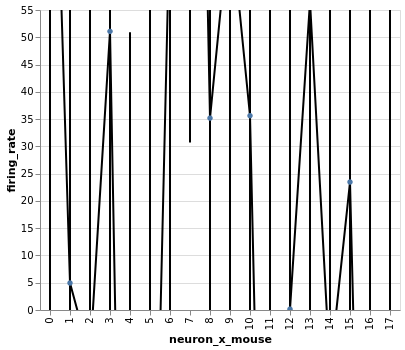

In [17]:
bw.plot_posteriors_slopes(x='neuron_x_mouse:O')

### Firing rate

We lost some detail in the data. This does not matter for posterior, but plotting data may suffer. Did was there another index column (like i_trial) other than ['neuron_x_mouse', 'mouse']?


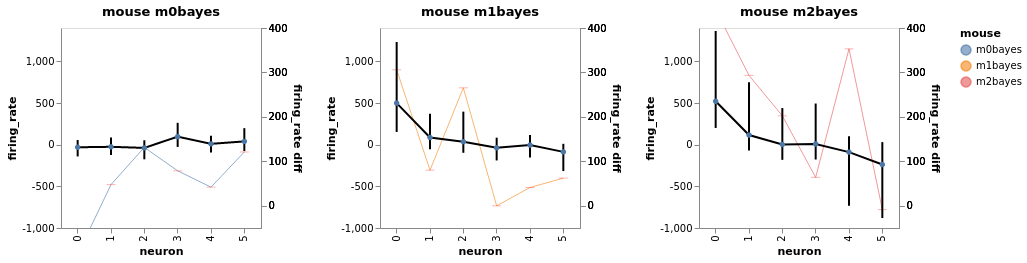

In [18]:
bw = BayesWindow(df, y='firing_rate', treatment='stim', condition='neuron_x_mouse', group='mouse')
bw.fit_slopes(model=models.model_hierarchical, do_make_change='subtract',
              progress_bar=False,
              dist_y='student',
              add_group_slope=True, add_group_intercept=False,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot(x='neuron', color='mouse', independent_axes=True, finalize=True)
bw.facet(column='mouse',width=200,height=200).display()

ANOVA may not be appropriate here: It considers every neuron. If we look hard enough, surely we'll find a responsive neuron or two out of hundreds?

In [19]:
bw = BayesWindow(df, y='firing_rate', treatment='stim', condition='neuron_x_mouse', group='mouse')

bw.fit_anova(formula='firing_rate ~ stim+ mouse + stim*mouse + neuron_x_mouse + stim * neuron_x_mouse');

firing_rate ~ stim+ mouse + stim*mouse + neuron_x_mouse + stim * neuron_x_mouse
                        sum_sq   df       F  PR(>F)
stim                    -0.00  1.0   -0.00    1.00
mouse                50713.29  1.0   56.71    0.02
stim:mouse              13.33  1.0    0.01    0.91
neuron_x_mouse       96583.95  1.0  108.00    0.01
stim:neuron_x_mouse  24669.96  1.0   27.59    0.03
Residual              1788.57  2.0     NaN     NaN


## Model quality

We lost some detail in the data. This does not matter for posterior, but plotting data may suffer. Did was there another index column (like i_trial) other than ['neuron', 'mouse']?


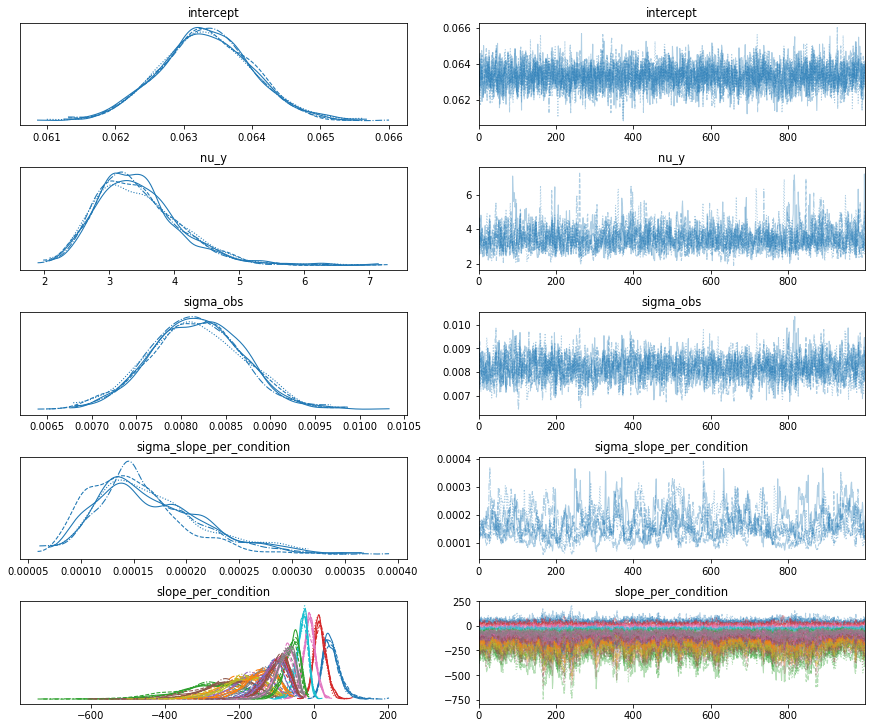

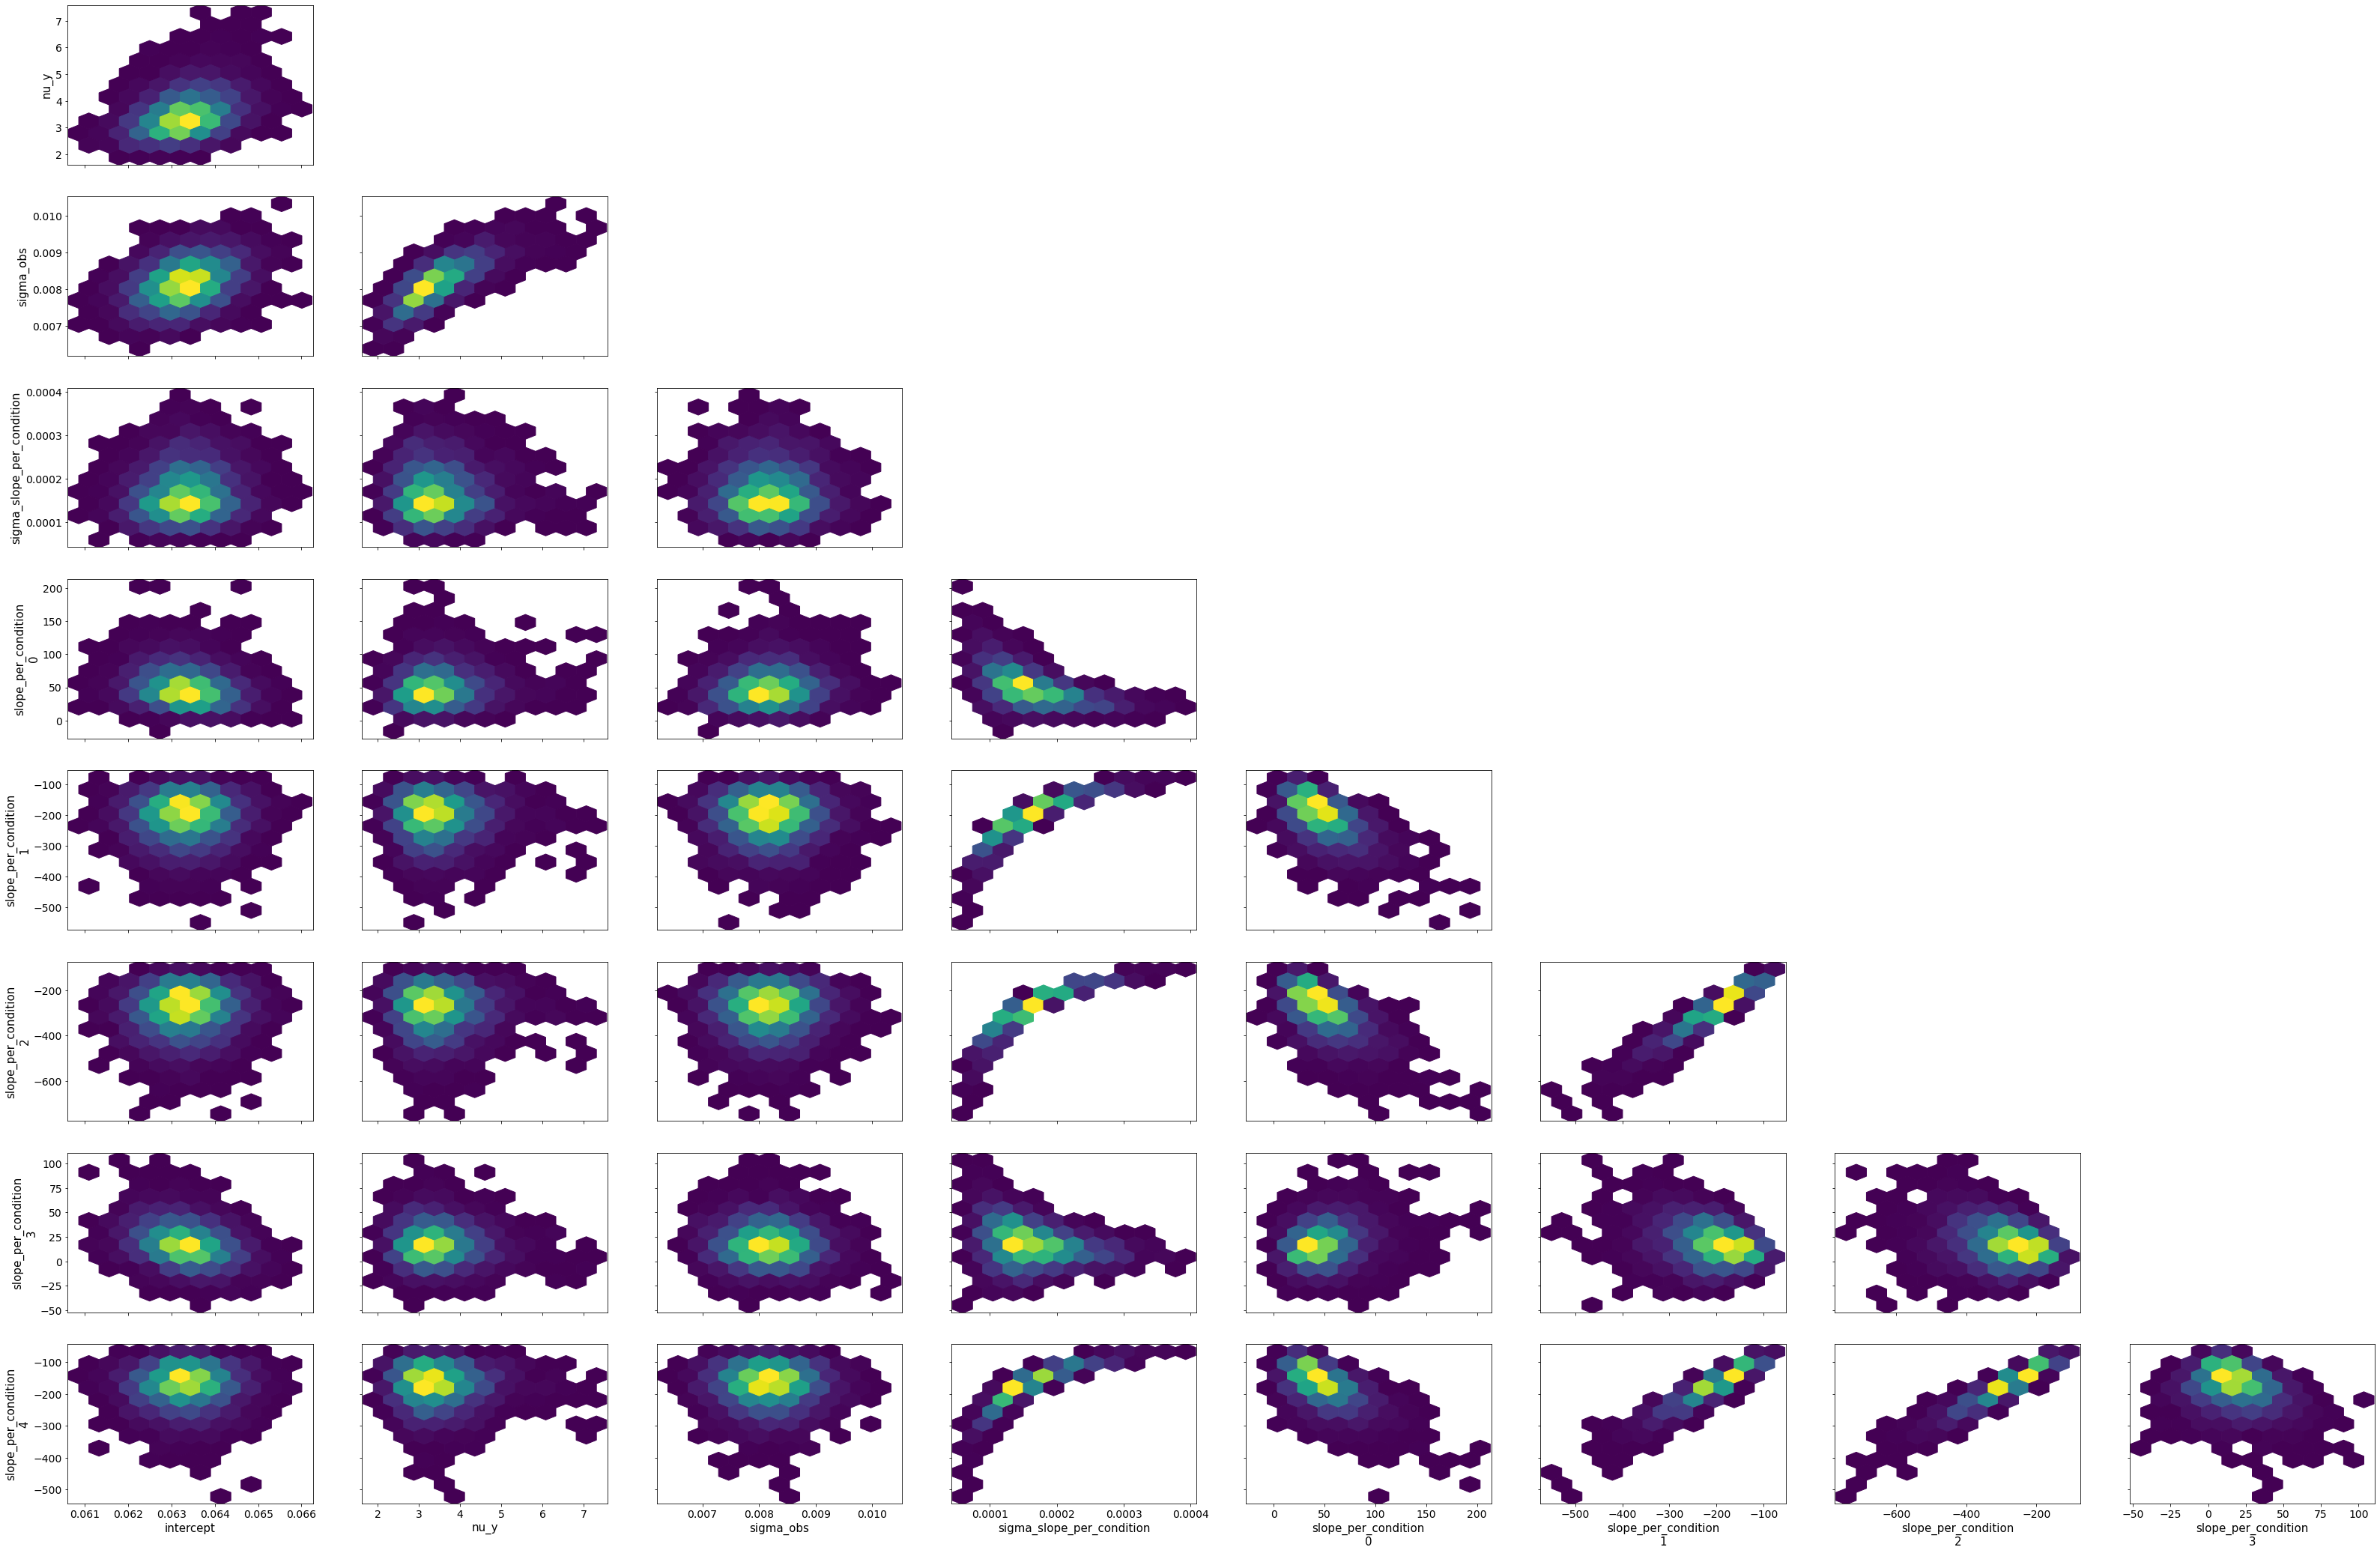

In [20]:
# Vanilla robust no interept or slope
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='student',
              robust_slopes=True,
              add_group_intercept=False,
              add_group_slope=False,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

We lost some detail in the data. This does not matter for posterior, but plotting data may suffer. Did was there another index column (like i_trial) other than ['neuron', 'mouse']?


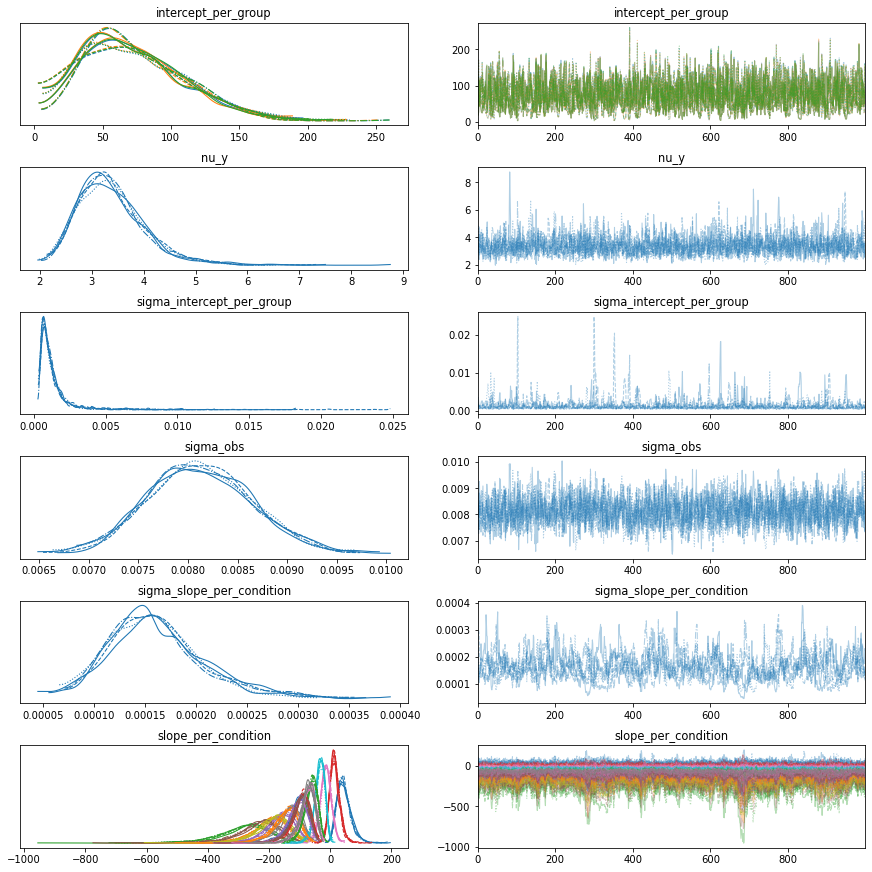

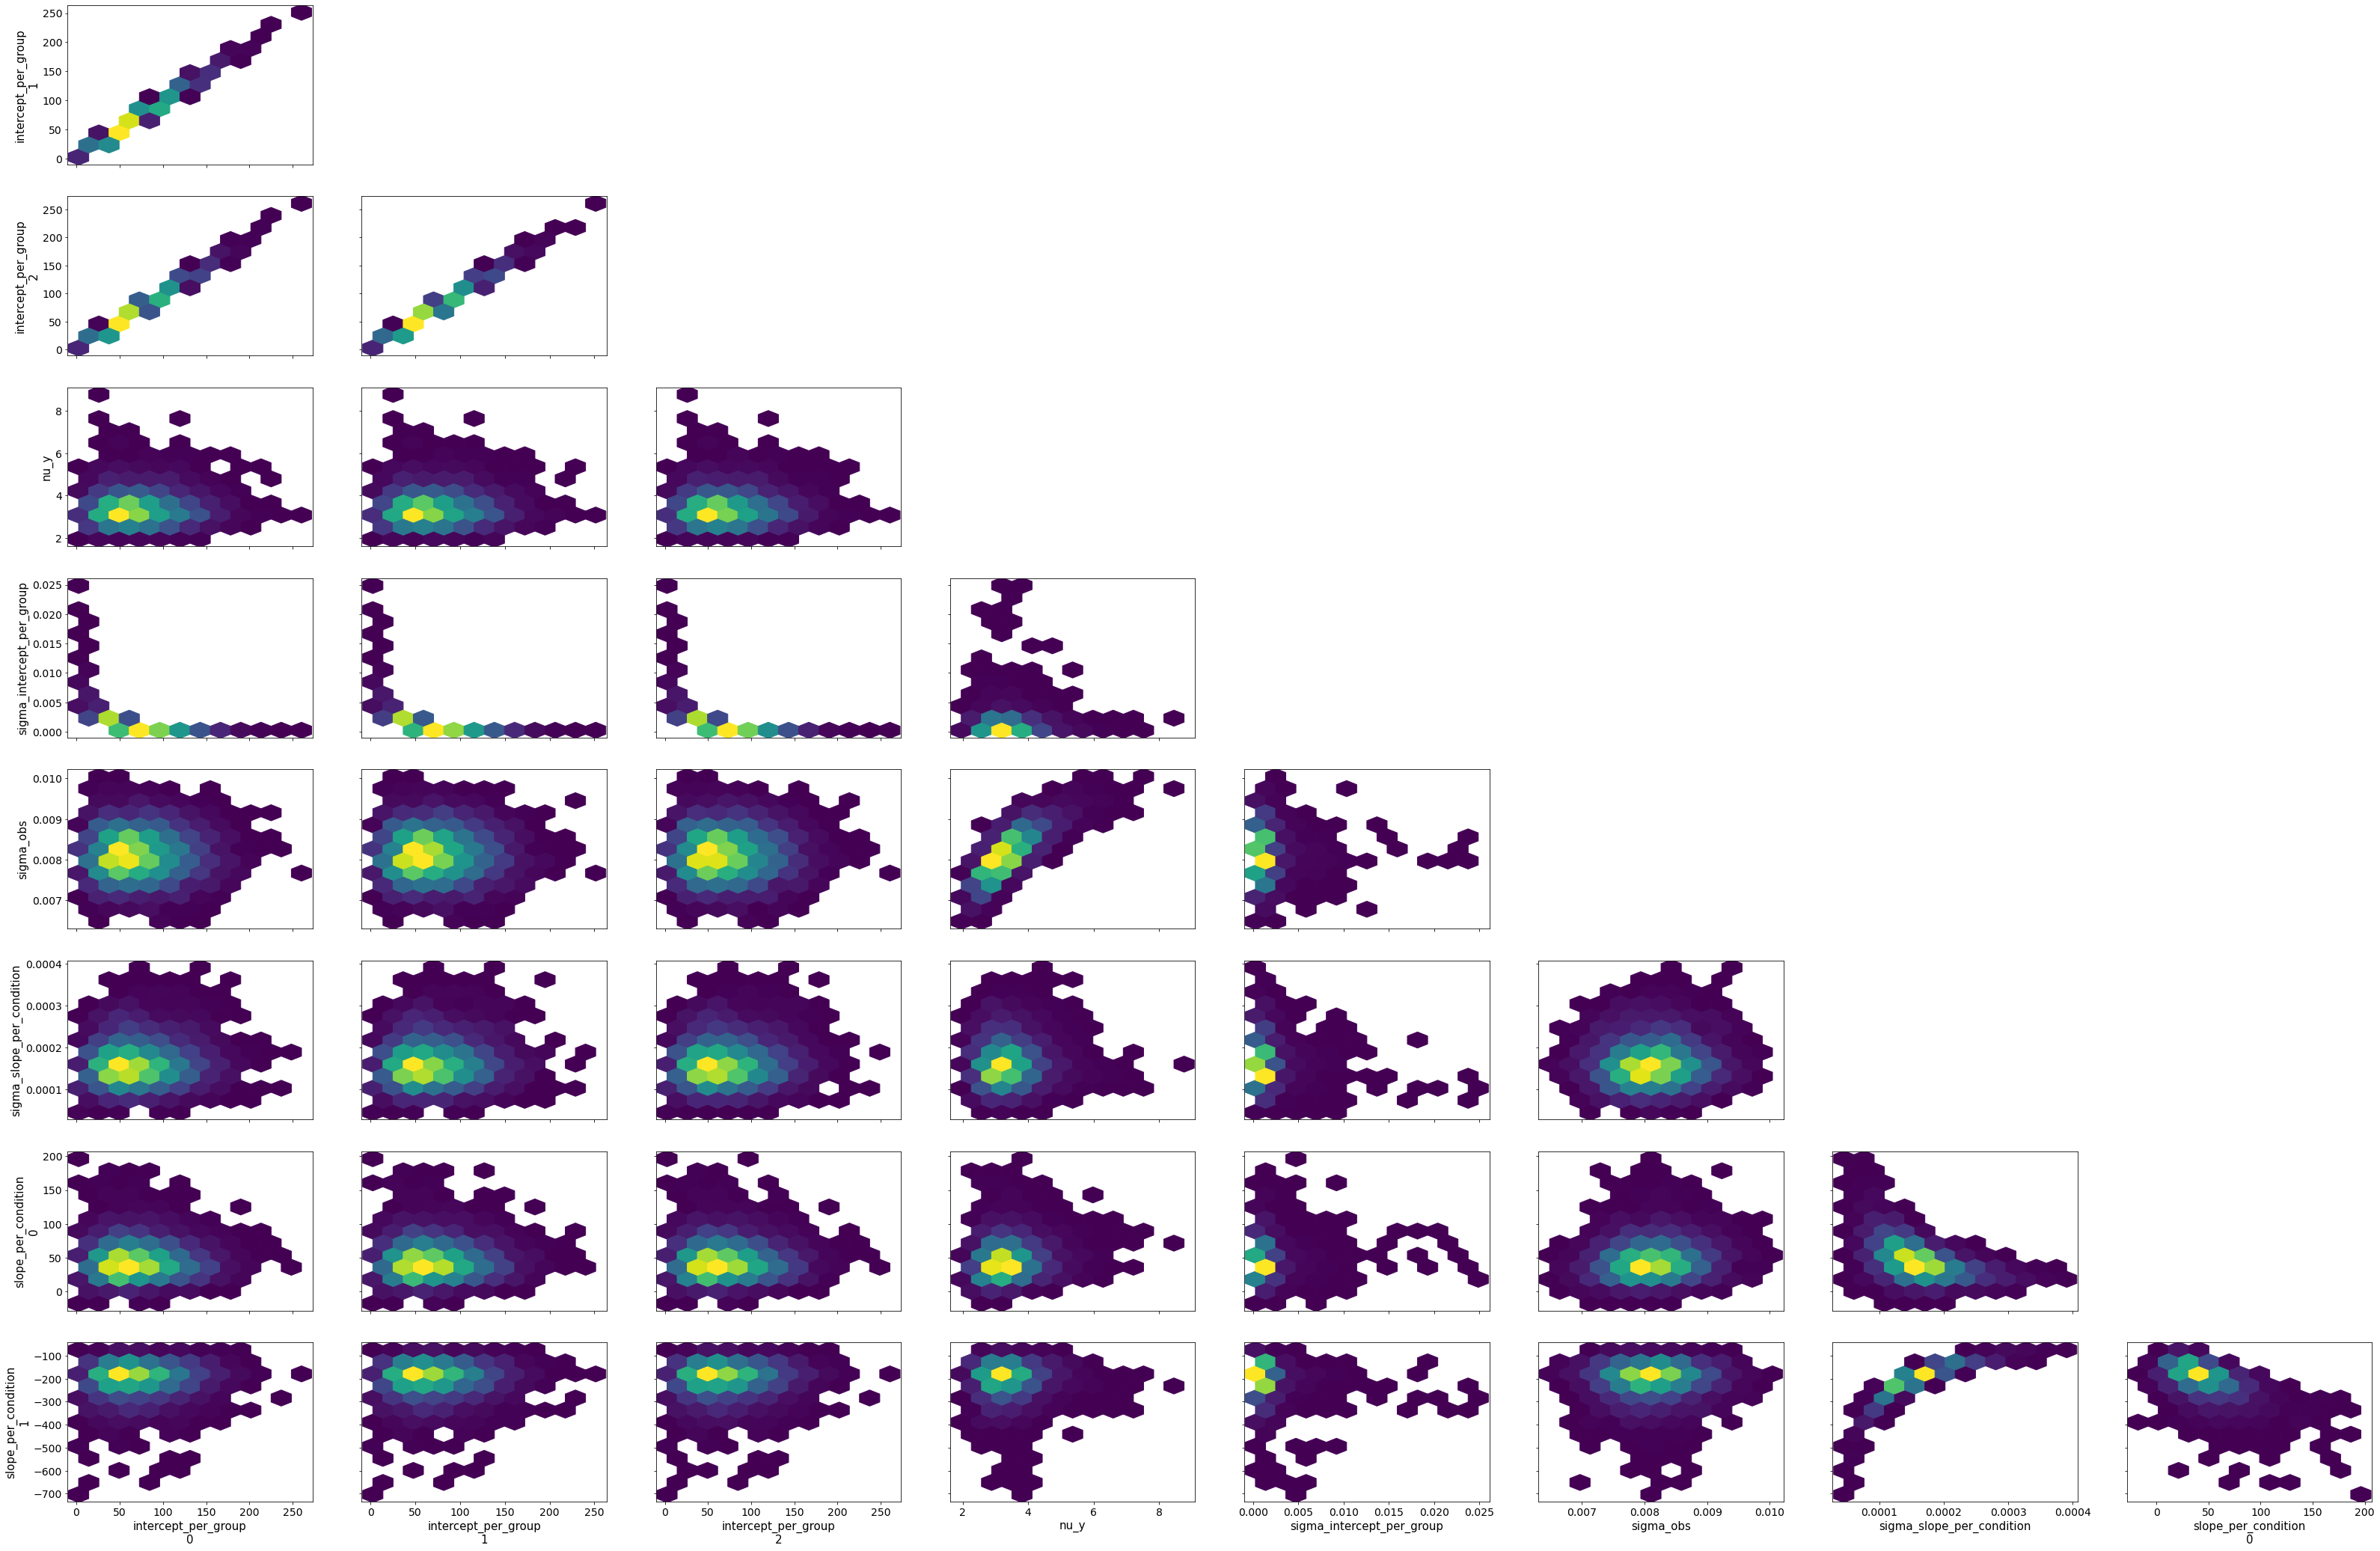

In [21]:
# Vanilla robust, intercept only
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='student',
              robust_slopes=True,
              add_group_intercept=True,
              add_group_slope=False,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

n(Divergences) = 2
We lost some detail in the data. This does not matter for posterior, but plotting data may suffer. Did was there another index column (like i_trial) other than ['neuron', 'mouse']?


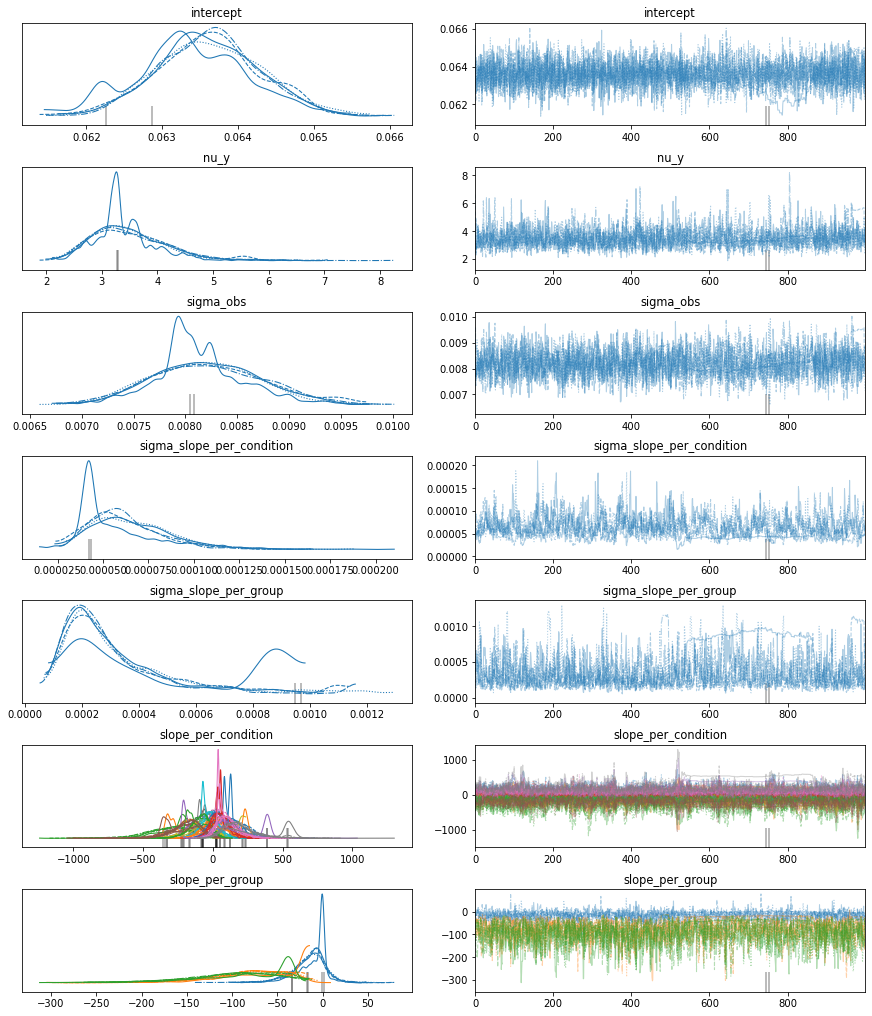

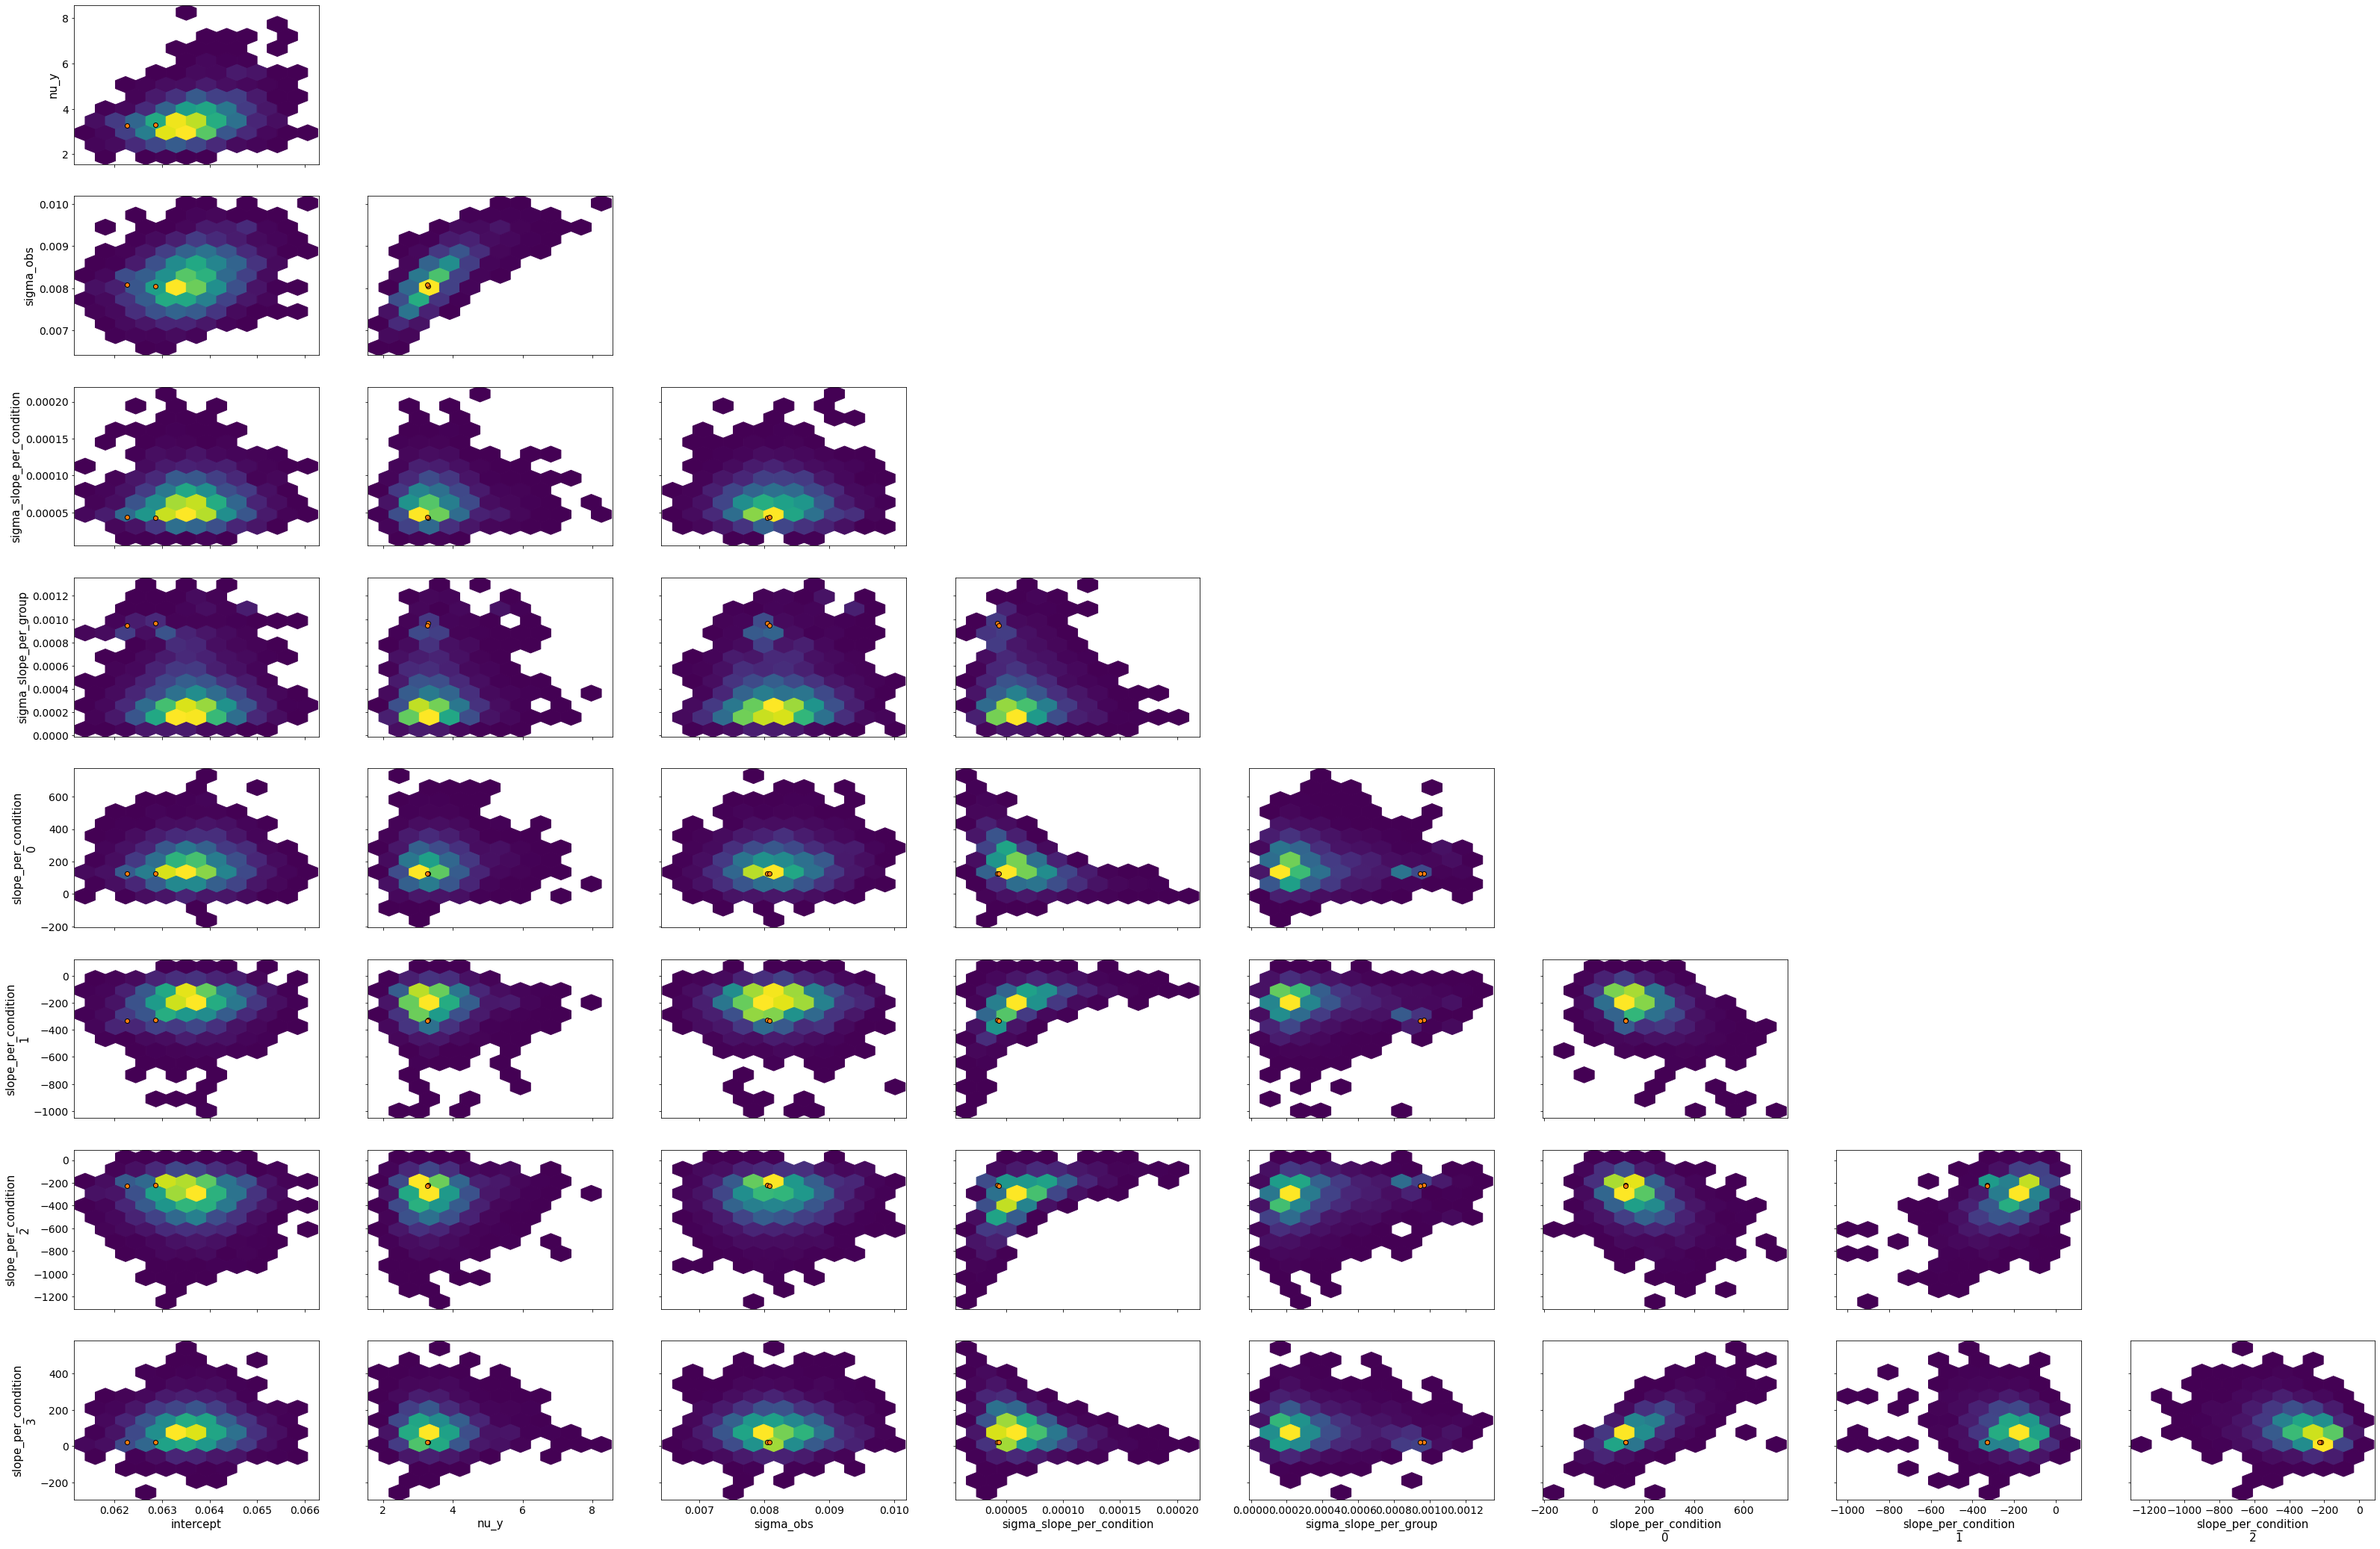

In [22]:
# Vanilla robust, slopes only
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='student',
              robust_slopes=True,
              add_group_intercept=False,
              add_group_slope=True,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

We lost some detail in the data. This does not matter for posterior, but plotting data may suffer. Did was there another index column (like i_trial) other than ['neuron', 'mouse']?


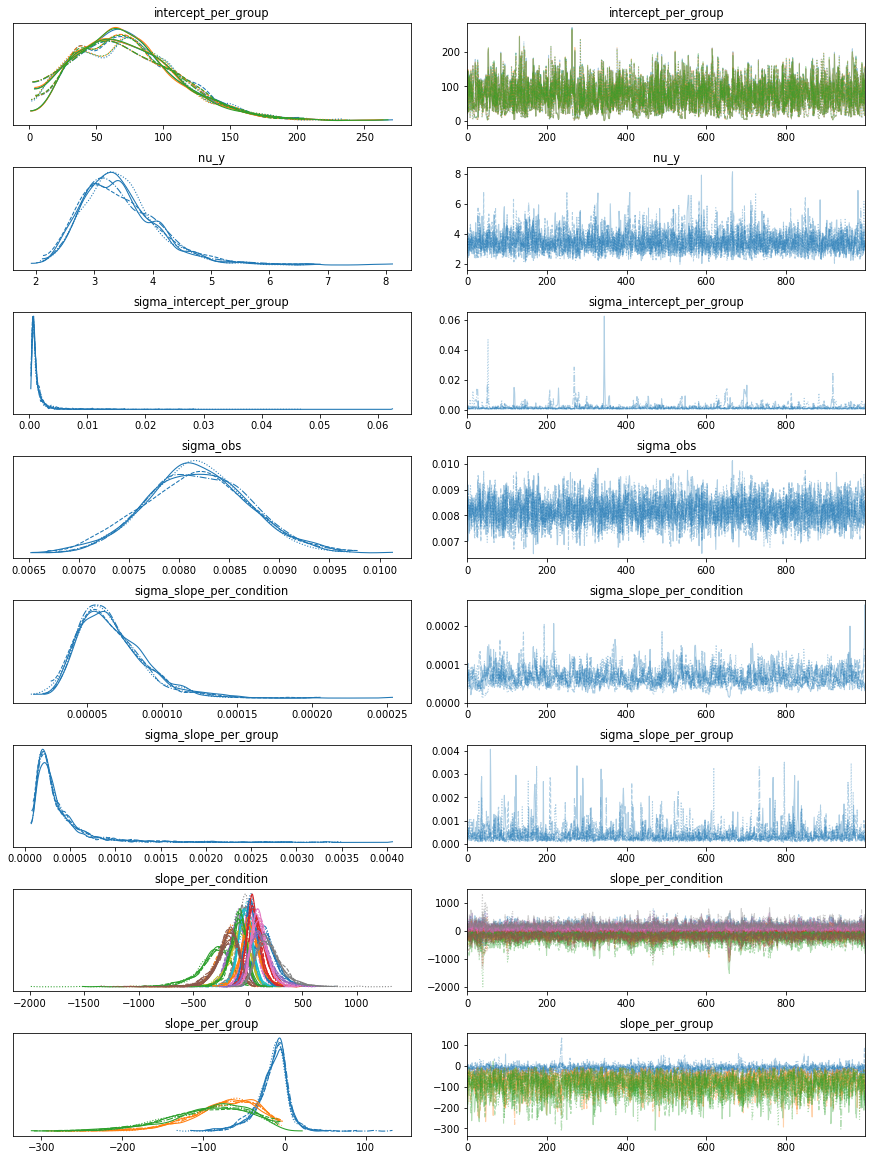

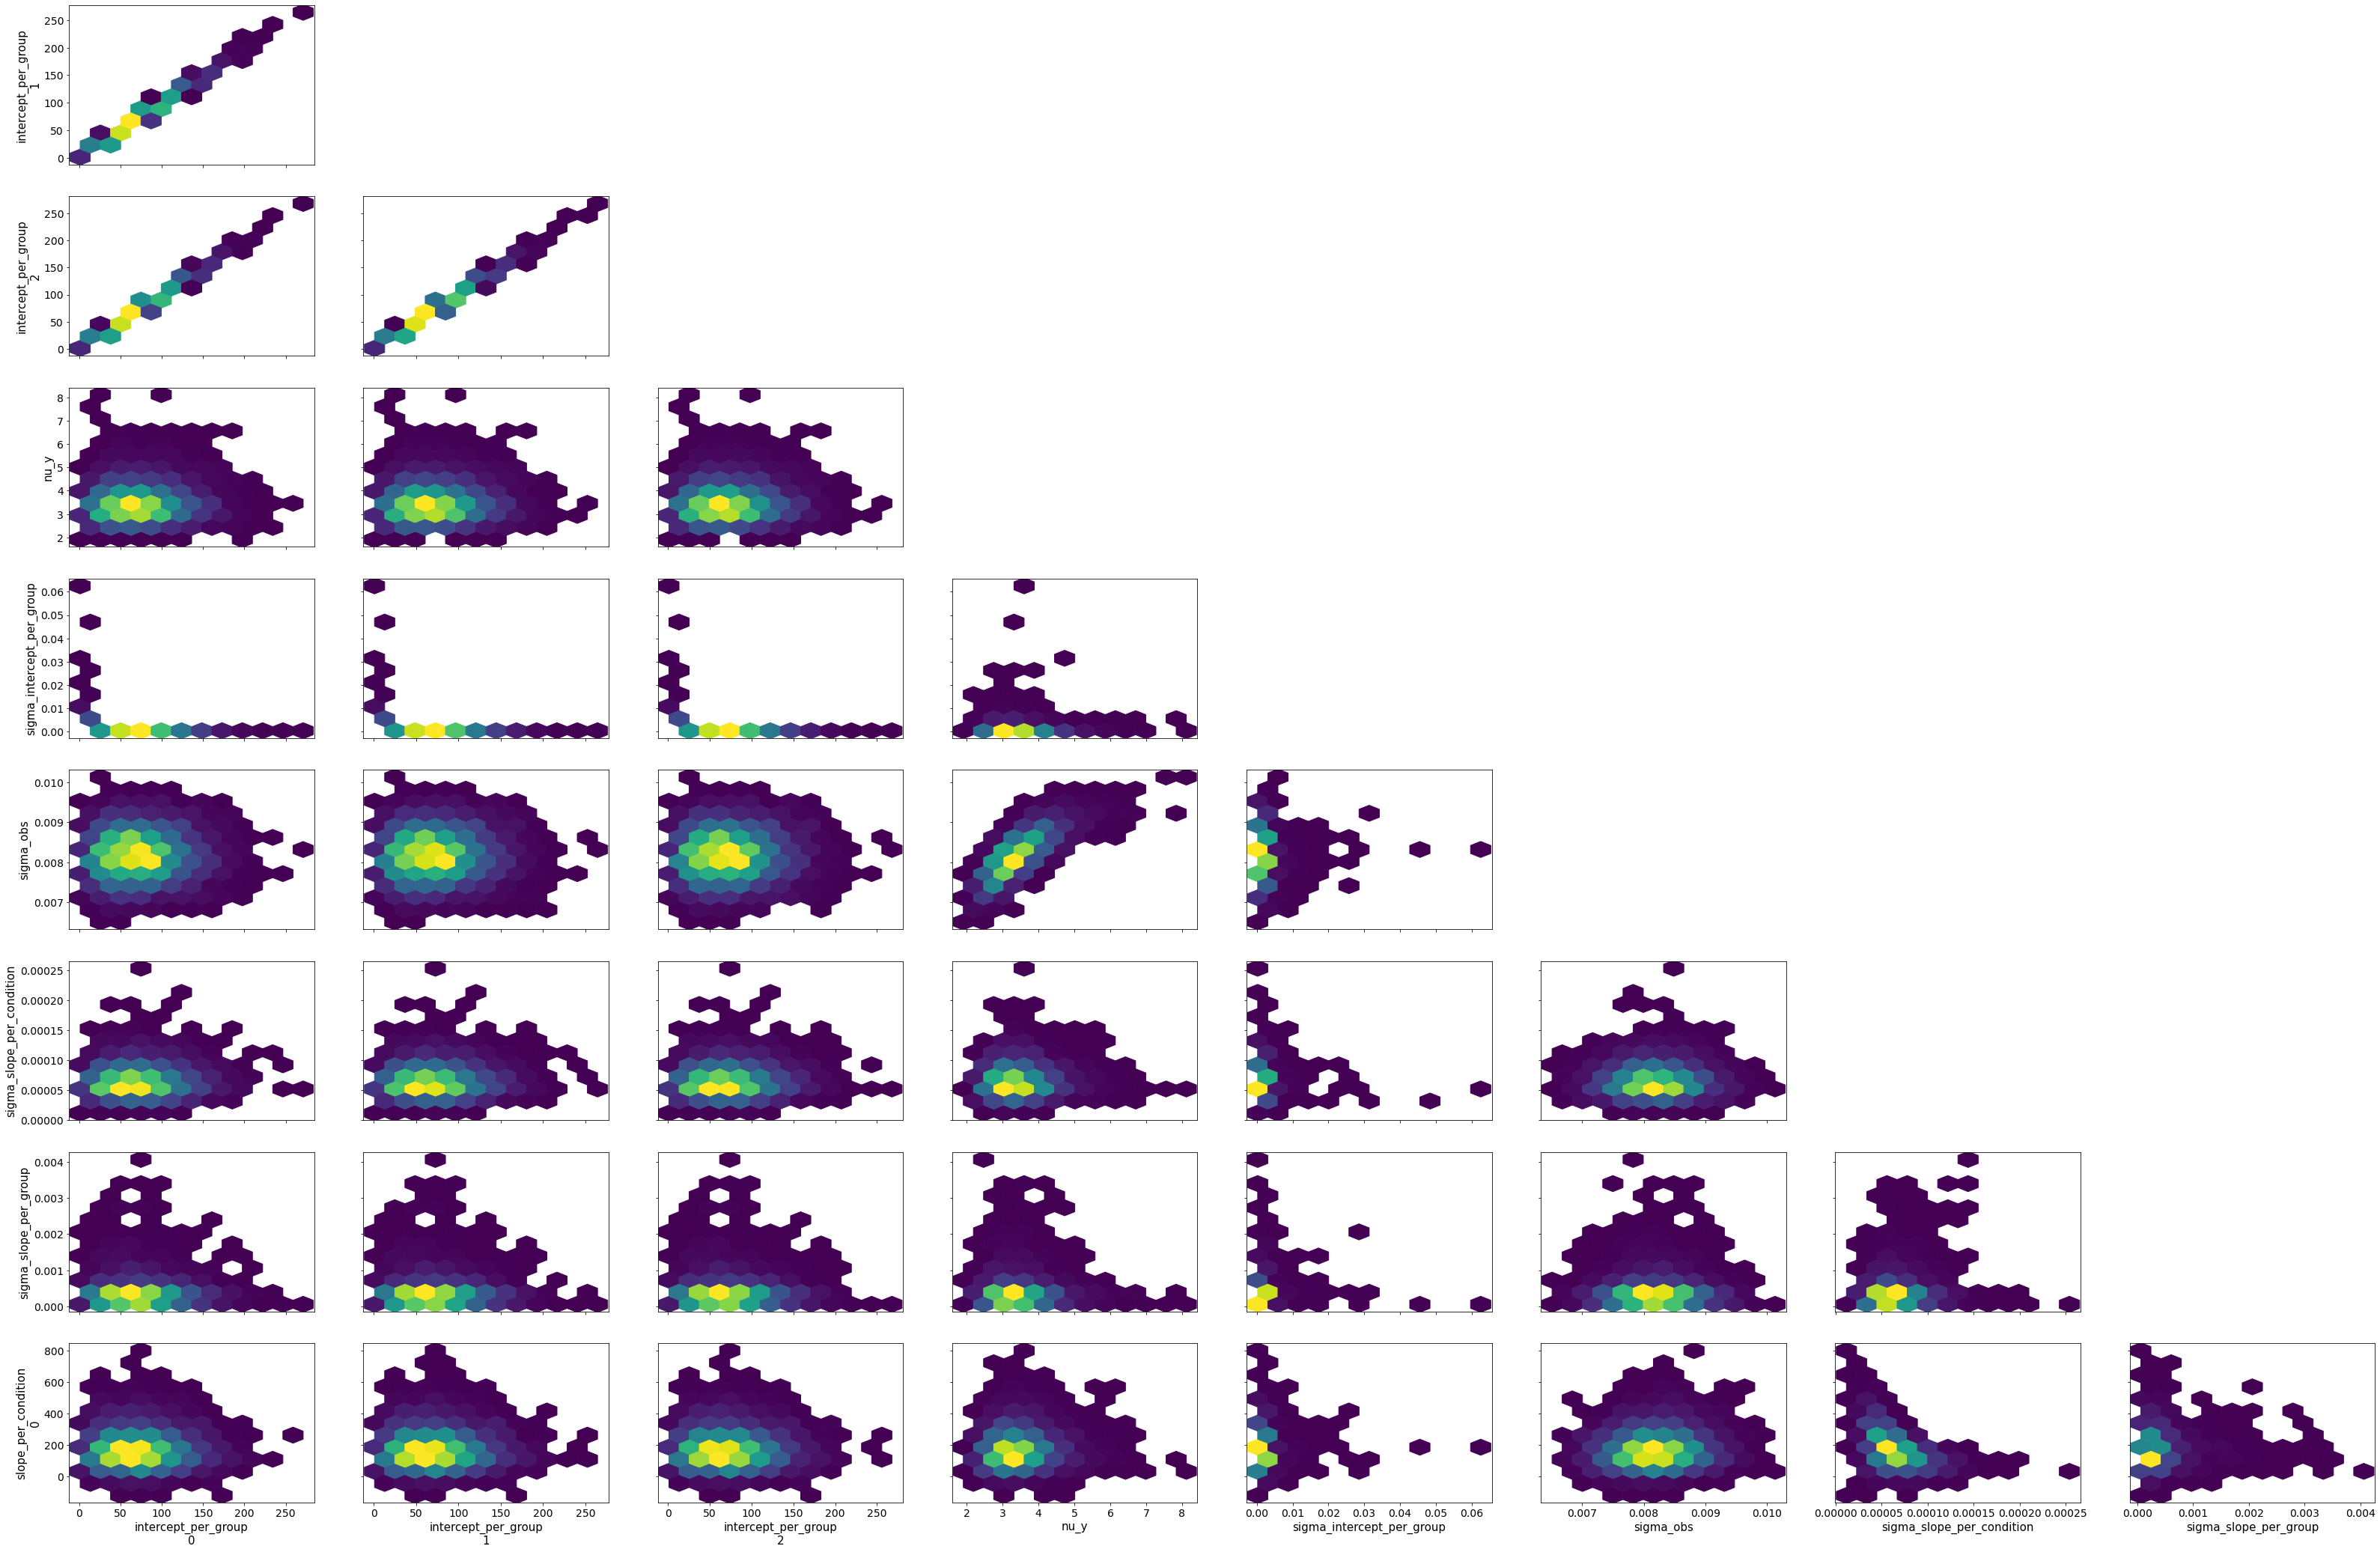

In [26]:
# Vanilla robust intercept and group
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='student',
              robust_slopes=True,
              add_group_intercept=True,
              add_group_slope=True,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

n(Divergences) = 38
We lost some detail in the data. This does not matter for posterior, but plotting data may suffer. Did was there another index column (like i_trial) other than ['neuron', 'mouse']?


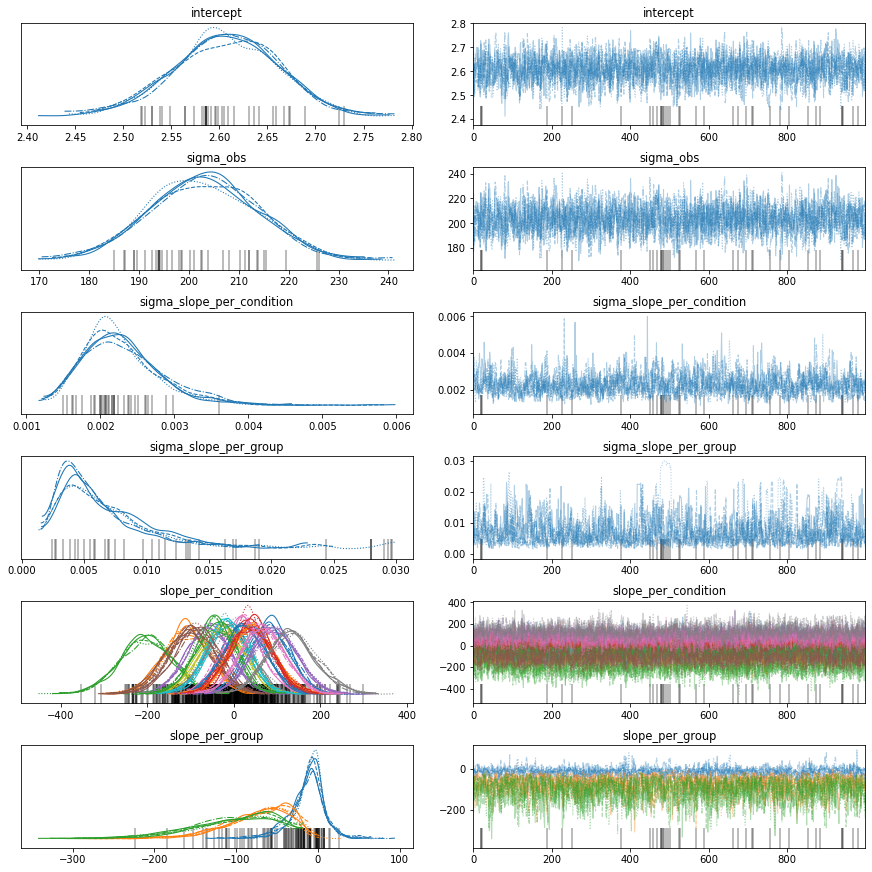

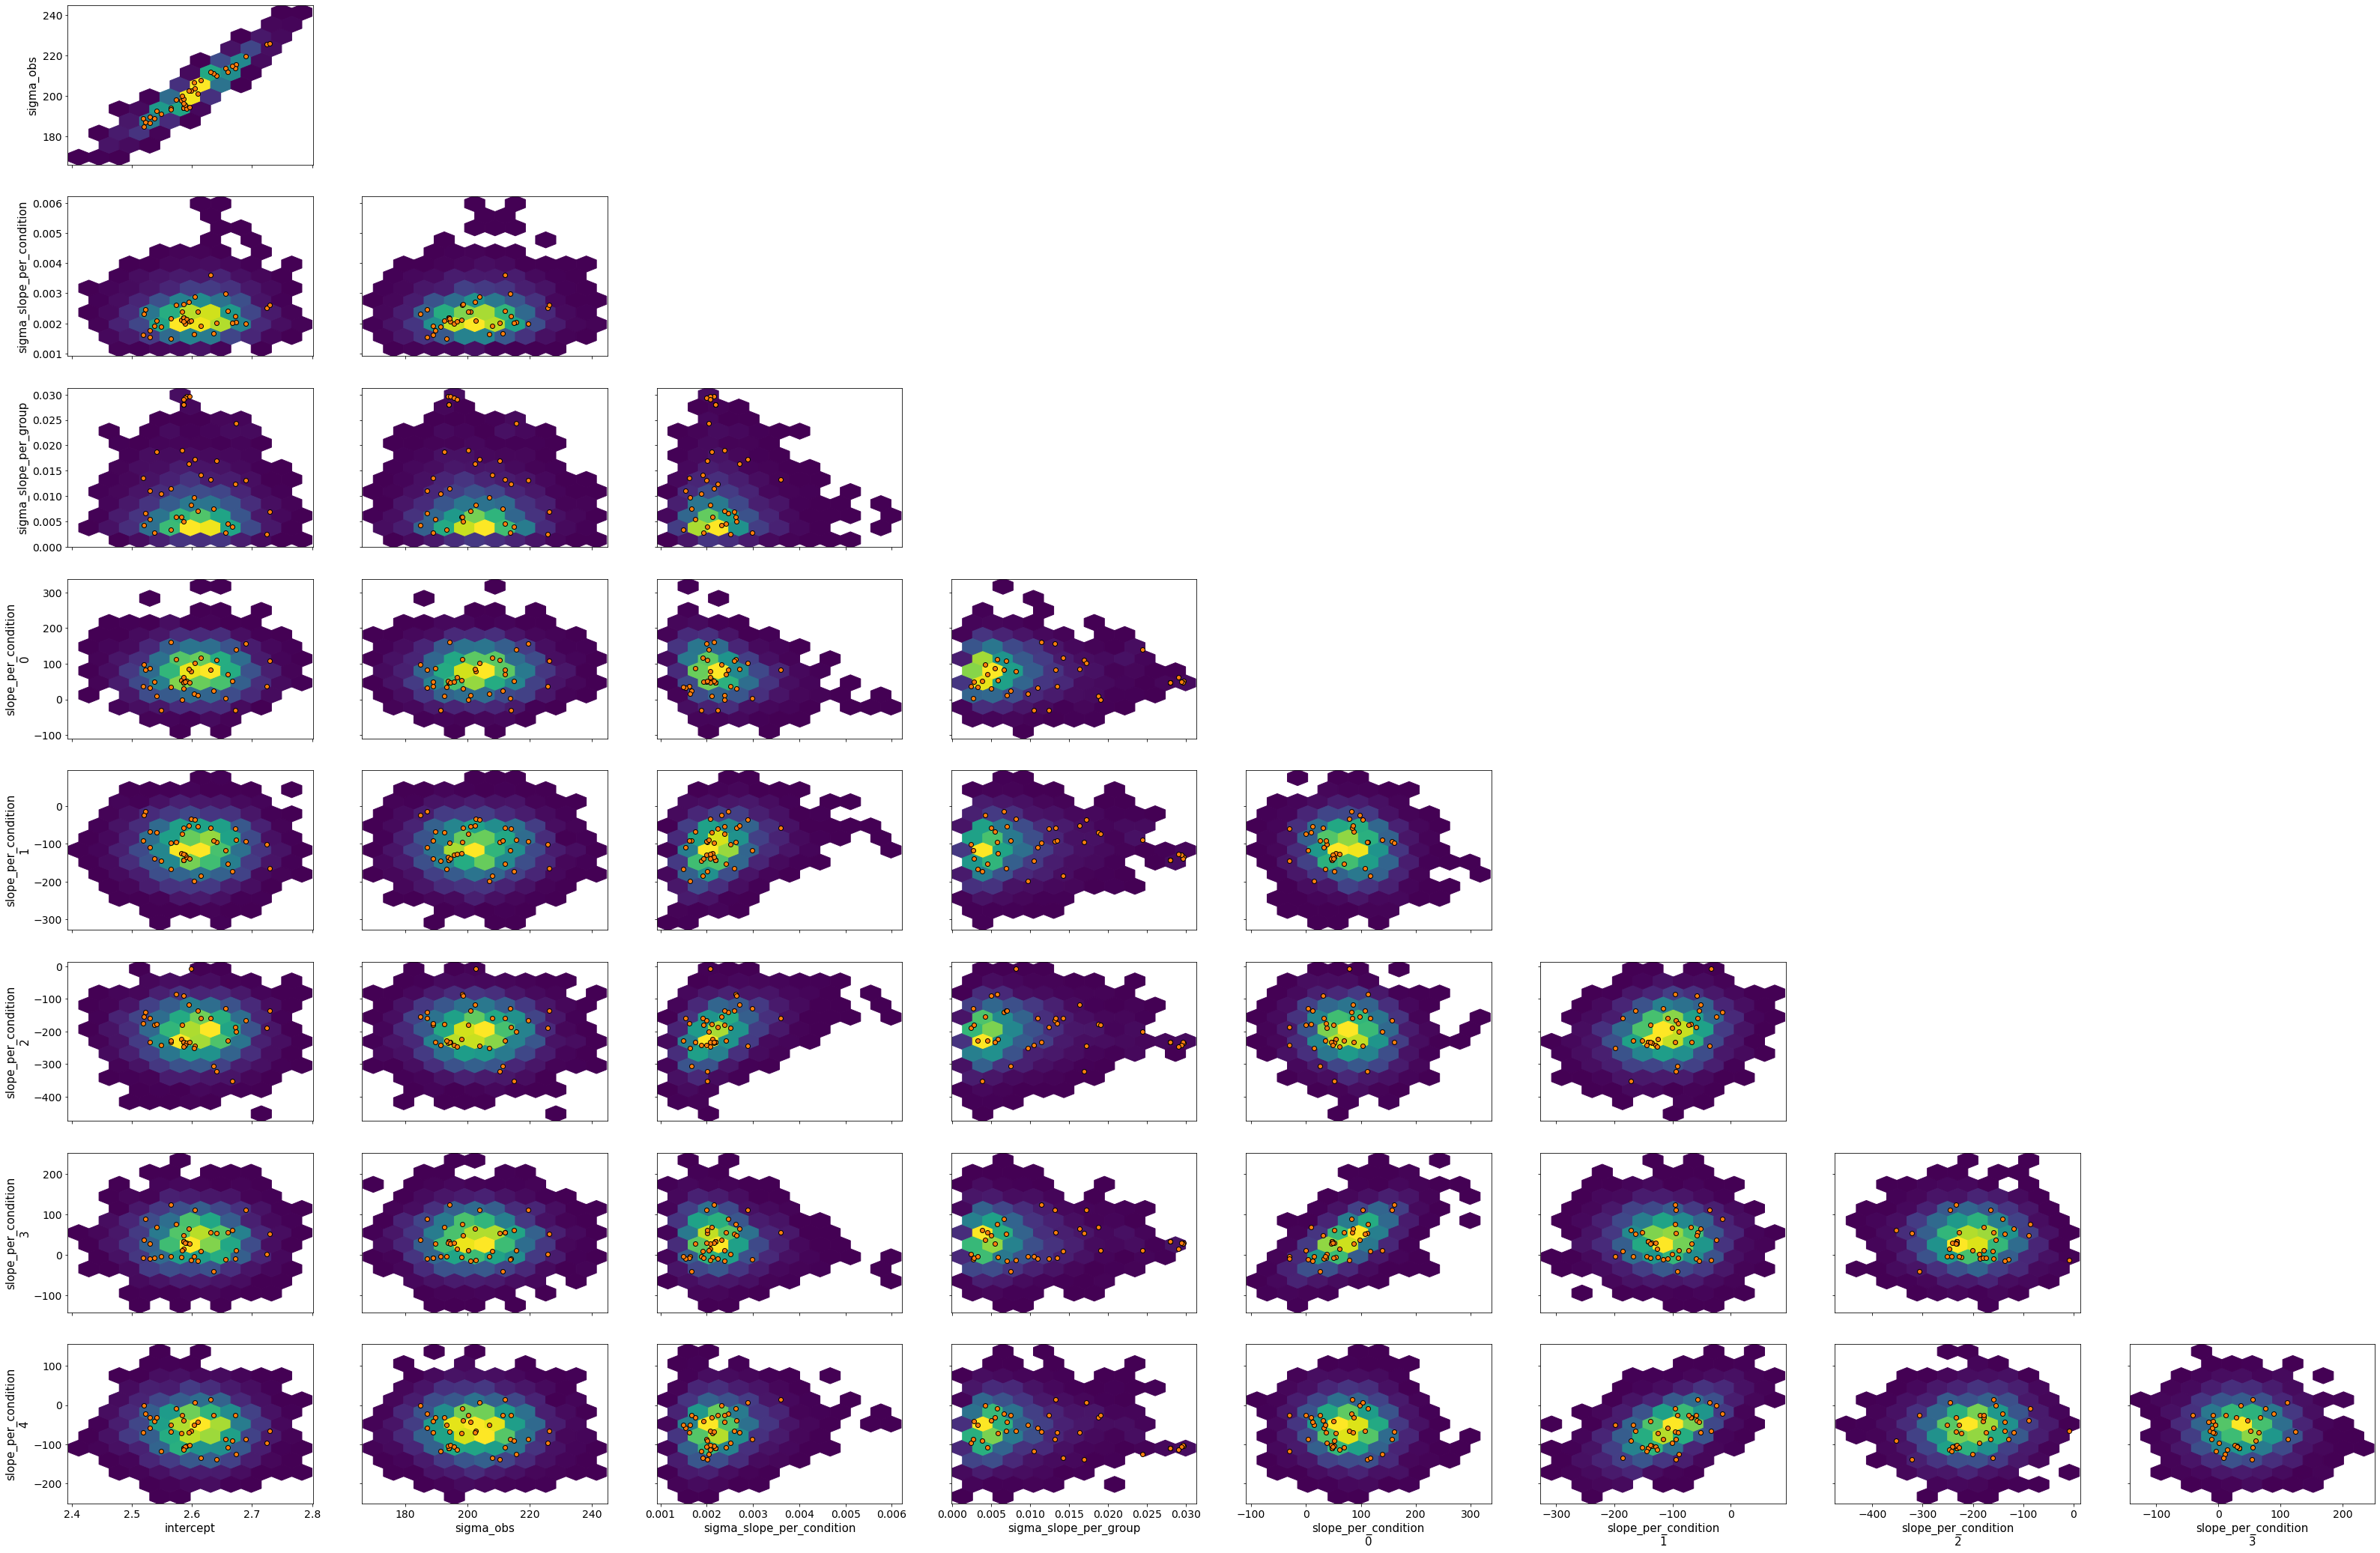

In [27]:
# Gamma GLM slope only
reload(models)
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='gamma',
              robust_slopes=False,
              add_group_intercept=False,
              add_group_slope=True,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

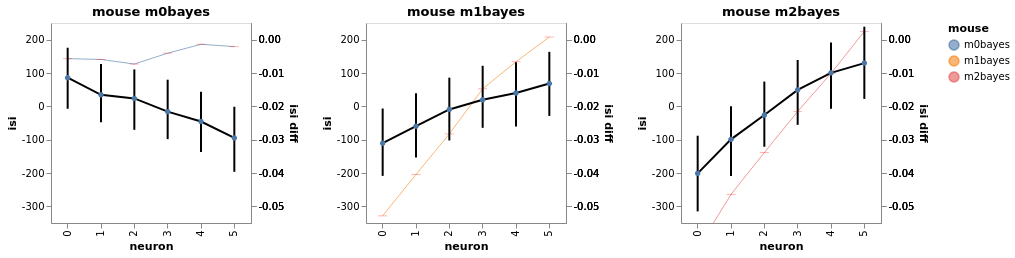

In [28]:
bw.plot(x='neuron', color='mouse', independent_axes=True, finalize=True)
bw.facet(column='mouse',width=200,height=200).display()

We lost some detail in the data. This does not matter for posterior, but plotting data may suffer. Did was there another index column (like i_trial) other than ['neuron', 'mouse']?


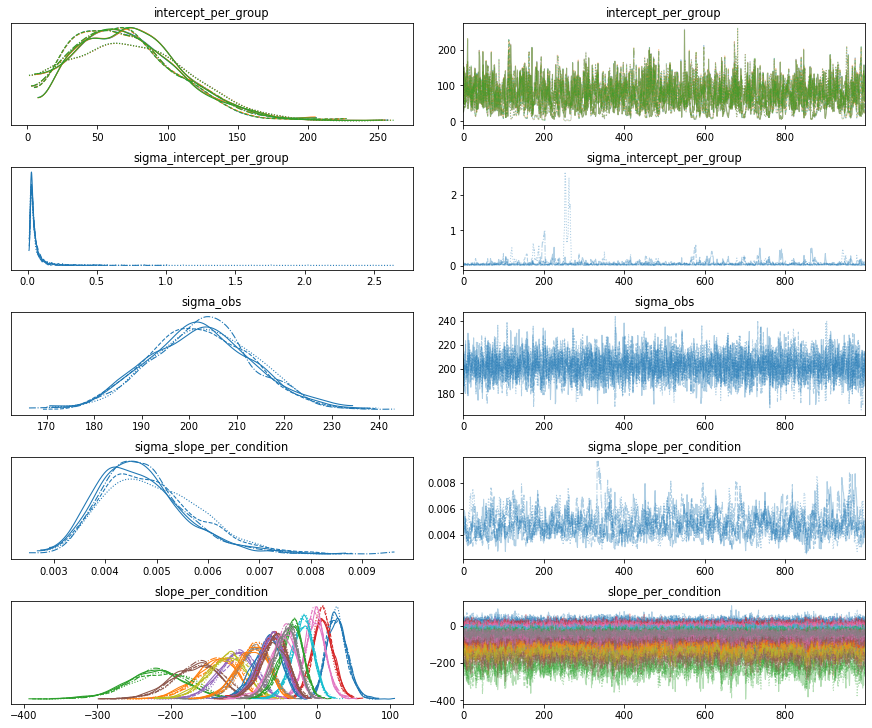

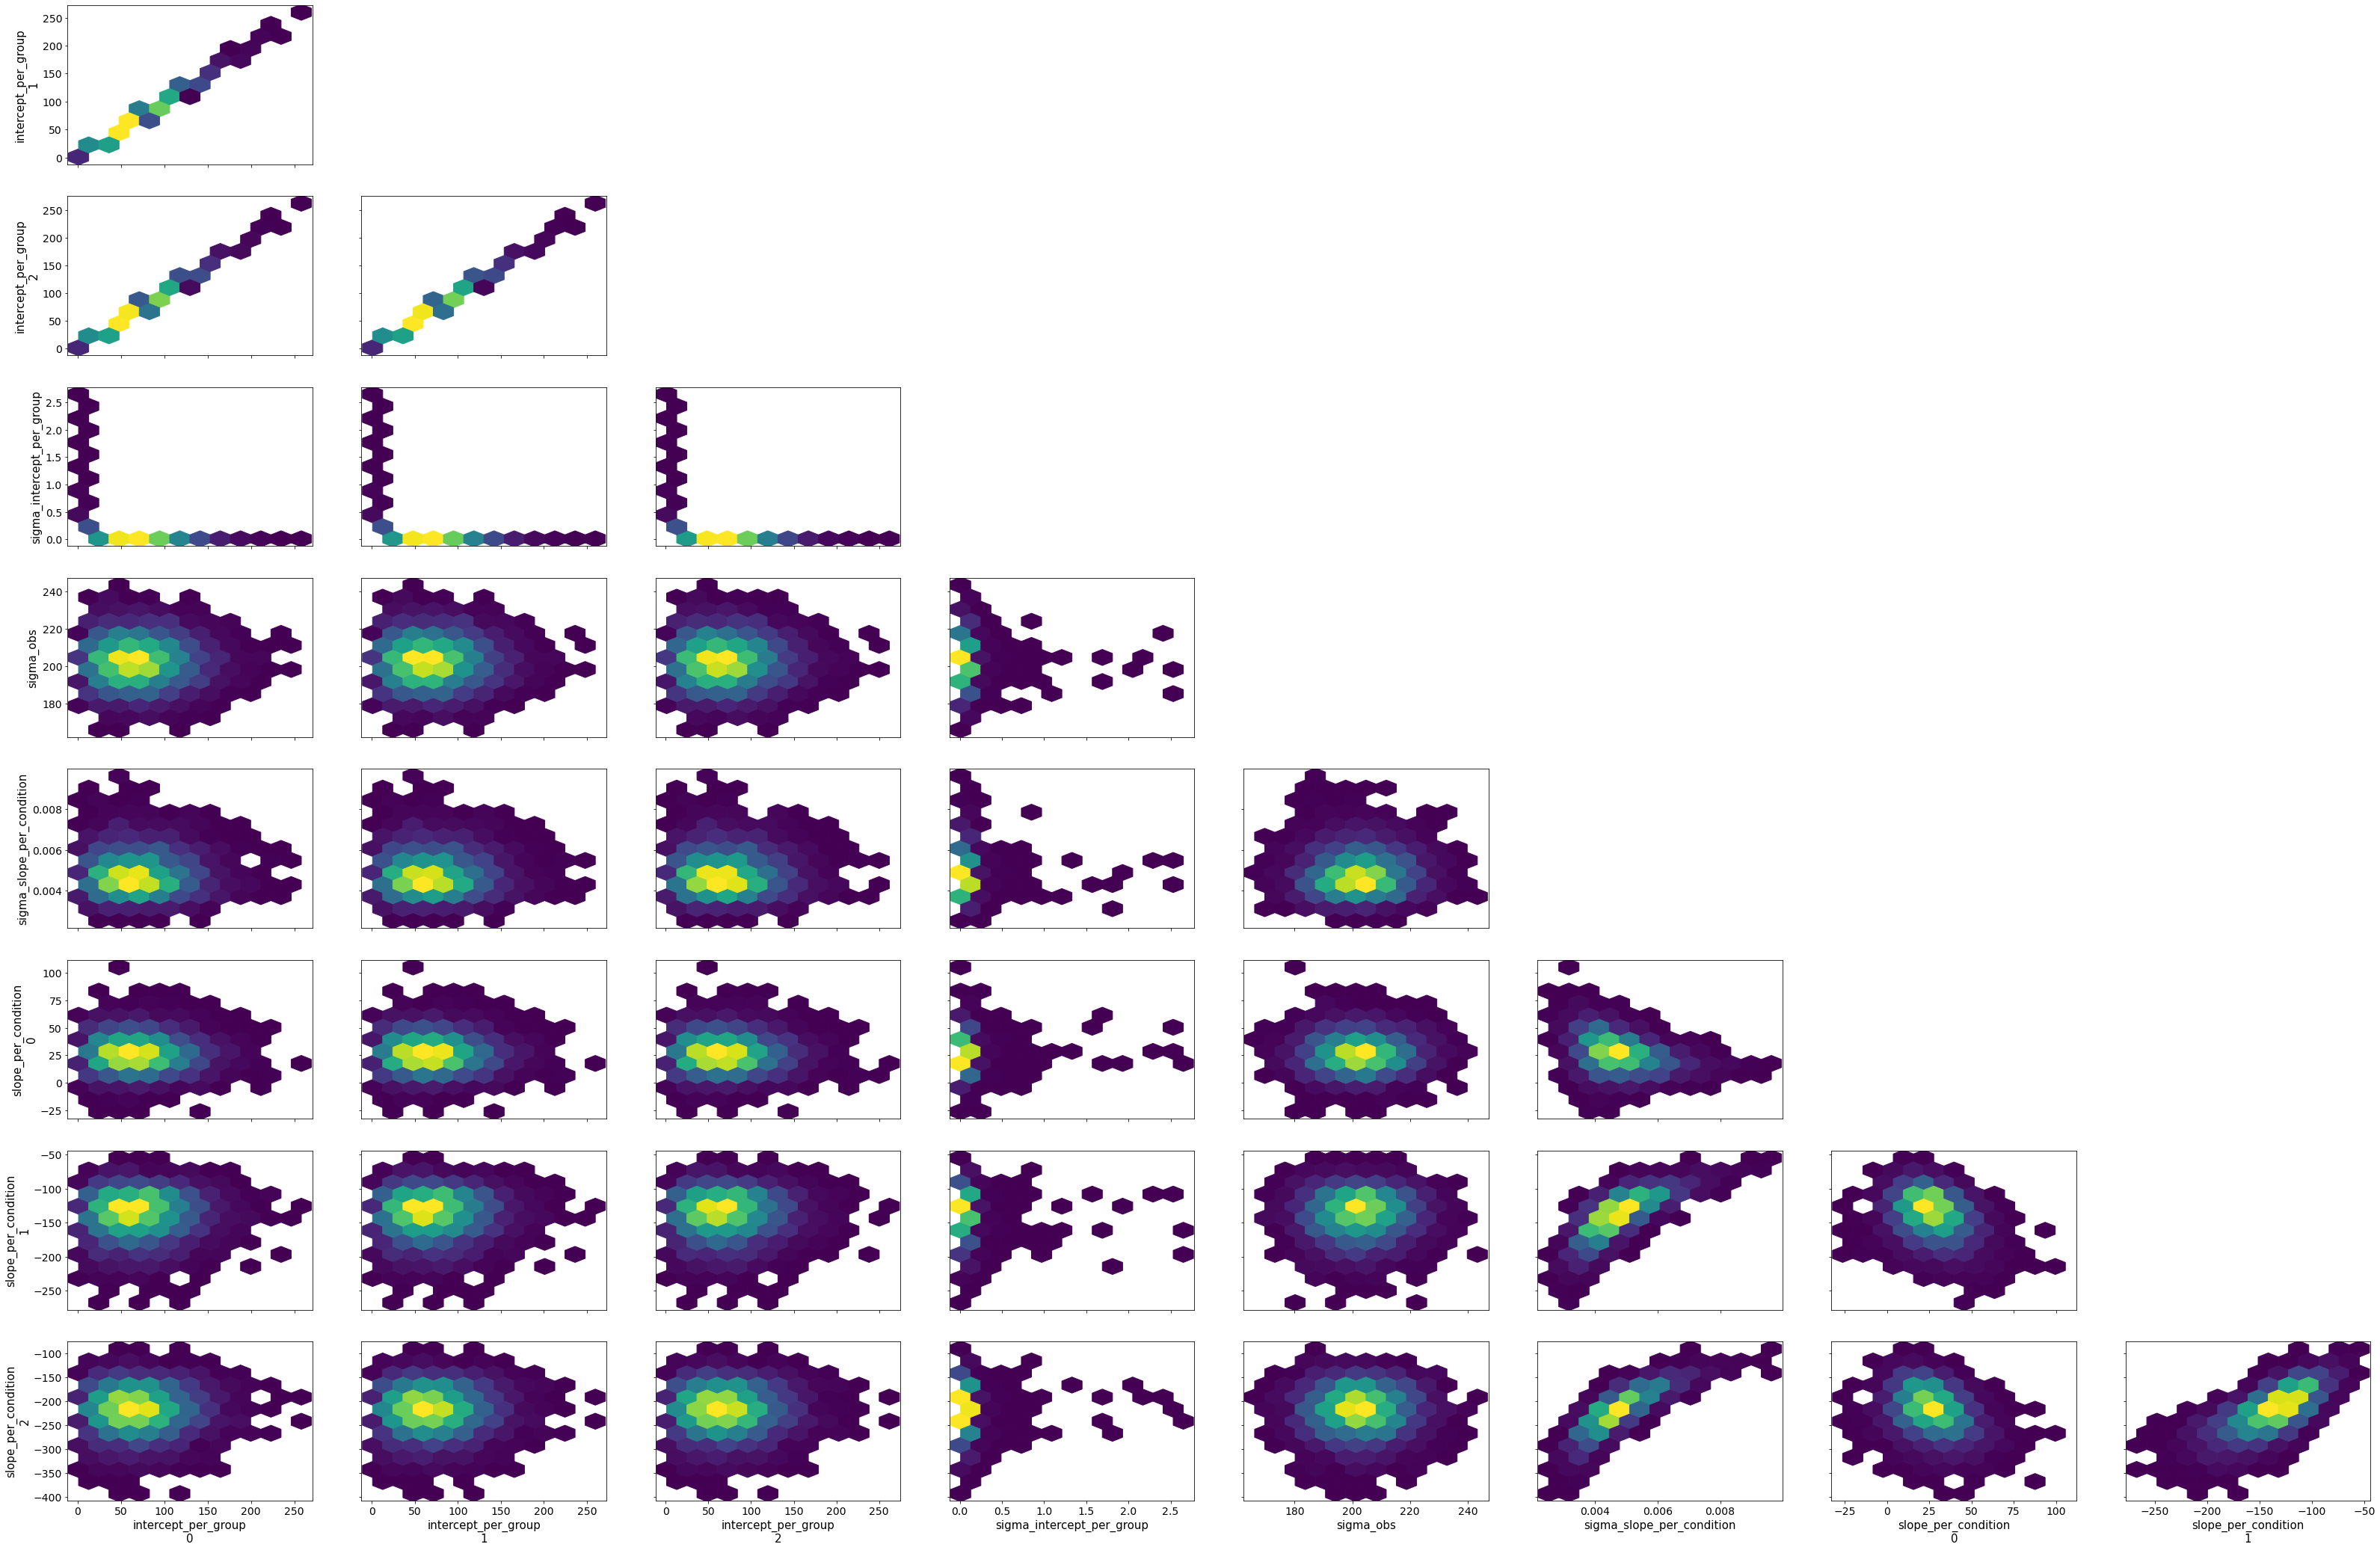

In [29]:
# Gamma GLM intercept only
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='gamma',
              robust_slopes=False,
              add_group_intercept=True,
              add_group_slope=False,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

group slopes+ group intercepts=>divergences

## LME fails

In [3]:
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron_x_mouse'], group='mouse',)
bw.fit_lme(add_data=False,add_group_intercept=True, add_group_slope=False)

Using formula isi ~ (1|mouse) + stim| neuron_x_mouse__0 + stim|neuron_x_mouse__1 + stim|neuron_x_mouse__2 + stim|neuron_x_mouse__3 + stim|neuron_x_mouse__4 + stim|neuron_x_mouse__5 + stim|neuron_x_mouse__6 + stim|neuron_x_mouse__7 + stim|neuron_x_mouse__8 + stim|neuron_x_mouse__9 + stim|neuron_x_mouse__10 + stim|neuron_x_mouse__11 + stim|neuron_x_mouse__12 + stim|neuron_x_mouse__13 + stim|neuron_x_mouse__14 + stim|neuron_x_mouse__15 + stim|neuron_x_mouse__16 + stim|neuron_x_mouse__17
                            Coef. Std.Err.        z  P>|z|  [0.025  0.975]
Intercept                   0.079    0.014    5.791  0.000   0.052   0.106
1 | mouse                  -0.007    0.007   -1.009  0.313  -0.021   0.007
stim | neuron_x_mouse__0    0.005    0.002    2.082  0.037   0.000   0.010
stim | neuron_x_mouse__1   -0.004    0.002   -1.532  0.126  -0.009   0.001
stim | neuron_x_mouse__2   -0.012    0.002   -5.031  0.000  -0.017  -0.008
stim | neuron_x_mouse__3   -0.018    0.002   -7.277  0.000  -

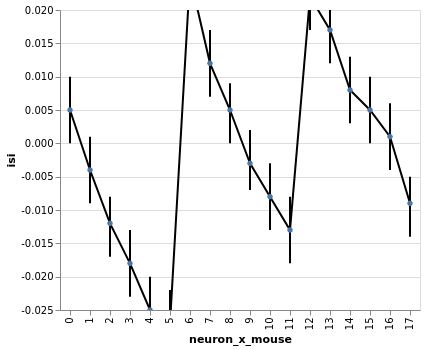

'Proper faceting will work when data addition is implemented in fit_lme()'

In [4]:
bw.plot_posteriors_slopes(x='neuron_x_mouse:O').display()
#bw.facet(column='mouse').display()
"Proper faceting will work when data addition is implemented in fit_lme()"

In [5]:
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron_x_mouse'], group='mouse',)
bw.fit_lme(add_data=False,add_group_intercept=True, add_group_slope=True)

Using formula isi ~ (stim|mouse) + stim| neuron_x_mouse__0 + stim|neuron_x_mouse__1 + stim|neuron_x_mouse__2 + stim|neuron_x_mouse__3 + stim|neuron_x_mouse__4 + stim|neuron_x_mouse__5 + stim|neuron_x_mouse__6 + stim|neuron_x_mouse__7 + stim|neuron_x_mouse__8 + stim|neuron_x_mouse__9 + stim|neuron_x_mouse__10 + stim|neuron_x_mouse__11 + stim|neuron_x_mouse__12 + stim|neuron_x_mouse__13 + stim|neuron_x_mouse__14 + stim|neuron_x_mouse__15 + stim|neuron_x_mouse__16 + stim|neuron_x_mouse__17
                            Coef. Std.Err.       z  P>|z|  [0.025  0.975]
Intercept                   0.074    0.010   7.707  0.000   0.055   0.093
stim | mouse               -0.007    0.007  -1.009  0.313  -0.021   0.007
stim | neuron_x_mouse__0    0.003    0.003   0.926  0.354  -0.003   0.009
stim | neuron_x_mouse__1   -0.006    0.003  -1.809  0.071  -0.012   0.000
stim | neuron_x_mouse__2   -0.015    0.003  -4.457  0.000  -0.021  -0.008
stim | neuron_x_mouse__3   -0.020    0.003  -6.157  0.000  -0.02

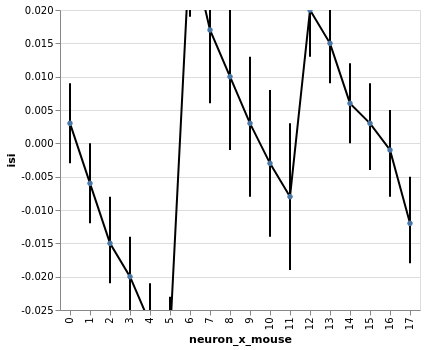

In [6]:
bw.plot_posteriors_slopes(x='neuron_x_mouse:O').display()

Need nested design, but get singular matrix:

In [7]:
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron_x_mouse'], group='mouse',)
try:
    bw.fit_lme(add_data=False,add_group_intercept=True, add_group_slope=True, add_nested_group=True)
except Exception as e:
    print(e)



Using formula isi ~ (stim|mouse) + stim| neuron_x_mouse__0:mouse + stim|neuron_x_mouse__1:mouse + stim|neuron_x_mouse__2:mouse + stim|neuron_x_mouse__3:mouse + stim|neuron_x_mouse__4:mouse + stim|neuron_x_mouse__5:mouse + stim|neuron_x_mouse__6:mouse + stim|neuron_x_mouse__7:mouse + stim|neuron_x_mouse__8:mouse + stim|neuron_x_mouse__9:mouse + stim|neuron_x_mouse__10:mouse + stim|neuron_x_mouse__11:mouse + stim|neuron_x_mouse__12:mouse + stim|neuron_x_mouse__13:mouse + stim|neuron_x_mouse__14:mouse + stim|neuron_x_mouse__15:mouse + stim|neuron_x_mouse__16:mouse + stim|neuron_x_mouse__17:mouse
Singular matrix
